In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir data
#!unrar x /content/drive/MyDrive/birds_dataset_train.rar /content/data

In [ ]:
#!mkdir data
#!unrar x /content/drive/MyDrive/birds_dataset_validation.rar /content/data

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import glob
from PIL import Image
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import torch
from PIL import Image
import numpy as np
import torchvision
from matplotlib.pyplot import figure
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def yolo_to_pascal_voc(x_center, y_center, w, h,  image_w, image_h):
    w = w * image_w
    h = h * image_h
    x1 = ((2 * x_center * image_w) - w)/2
    y1 = ((2 * y_center * image_h) - h)/2
    x2 = x1 + w
    y2 = y1 + h
    return [x1, y1, x2, y2]

In [ ]:
train_limit=10
valid_limit=3

In [ ]:
!rm /content/drive/MyDrive/birds/validation/validation_labels.csv
!rm /content/drive/MyDrive/birds/train/train_labels.csv

In [ ]:
os.chdir(r'/content/drive/MyDrive/birds/train/annotations')
myFiles = glob.glob('*.txt')

In [ ]:
final_df=[]
k=0
for item in myFiles:
    k+=1
    if k>=train_limit:
      break
    try:
      img=Image.open("/content/drive/MyDrive/birds/train/images/"+item[0:-3]+'jpg')  
      with open(item, 'rt') as fd:
          for first_line in fd.readlines():
            row=[]
            bbox_temp=[]
            splited = first_line.split();
            row.append(item[0:-3]+'jpg')
            try:
                x1,y1,x2,y2=yolo_to_pascal_voc(float(splited[1]),float(splited[2]),float(splited[3]),float(splited[4]),img.size[0],img.size[1])
                bbox_temp.append(float(x1))
                bbox_temp.append(float(y1))
                bbox_temp.append(float(x2))
                bbox_temp.append(float(y2))
                row.append(bbox_temp)
                final_df.append(row)
                
            except:
                print("file is not in YOLO format!")
    except:
      pass 
df = pd.DataFrame(final_df,columns=['image','bbox'])
df.to_csv("/content/drive/MyDrive/birds/train/train_labels.csv",index=False)

In [ ]:
os.chdir(r'/content/drive/MyDrive/birds/validation/annotations')
myFiles = glob.glob('*.txt')

In [ ]:
final_df=[]
k=0
for item in myFiles:
    k+=1
    if k>=valid_limit:
      break
    try:
      img=Image.open("/content/drive/MyDrive/birds/validation/images/"+item[0:-3]+'jpg') 
      with open(item, 'rt') as fd:
          for first_line in fd.readlines():
            row=[]
            bbox_temp=[]
            splited = first_line.split();

            row.append(item[0:-3]+'jpg')
            try:
                x1,y1,x2,y2=yolo_to_pascal_voc(float(splited[1]),float(splited[2]),float(splited[3]),float(splited[4]),img.size[0],img.size[1])
                bbox_temp.append(float(x1))
                bbox_temp.append(float(y1))
                bbox_temp.append(float(x2))
                bbox_temp.append(float(y2))
                row.append(bbox_temp)
                final_df.append(row)
            except:
                print("file is not in YOLO format!")
    except:
      pass
df = pd.DataFrame(final_df,columns=['image','bbox'])
df.to_csv("/content/drive/MyDrive/birds/validation/validation_labels.csv",index=False)

In [ ]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.Normalize([0.5], [0.5]),
 ])

In [ ]:
class BirdsDataset(torch.utils.data.Dataset):
  def __init__(self, root, phase,transform=None):
    self.root = root
    self.phase = phase

    self.targets = pd.read_csv(os.path.join(root, '{}_labels.csv'.format(phase)))
    self.imgs = list(dict.fromkeys(self.targets['image']))
    self.transform=transform

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, 'images', self.imgs[idx])
    img = Image.open(img_path).convert('RGB')
    img = F.to_tensor(img)
    #img = self.transform(img)
    #
    box_list = self.targets[self.targets['image'] == self.imgs[idx]]

    
    floats = [eval(x) for x in box_list['bbox'].values]
    boxes =torch.tensor(floats, dtype=torch.float32)
    
    #floats = self.transform(floats)

    #
    labels = torch.ones((len(box_list), ), dtype=torch.int64)
    #
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    #

    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
train_dataset = BirdsDataset('/content/drive/MyDrive/birds/train', 'train',transform)

valid_dataset = BirdsDataset('/content/drive/MyDrive/birds/validation', 'validation',transform)

print("train len :",train_dataset.__len__())
print("Valid len :",valid_dataset.__len__())

#print(train_dataset.__getitem__(1))
#print(valid_dataset.__getitem__(1))


train len : 5
Valid len : 2


In [ ]:
def new_concat(batch):
  return tuple(zip(*batch))
train_loader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=new_concat)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                            batch_size=1,
                            shuffle=True,
                            collate_fn=new_concat)

In [ ]:
next(iter(train_loader))

((tensor([[[0.5098, 0.5098, 0.5098,  ..., 0.9725, 0.9725, 0.9725],
           [0.5098, 0.5098, 0.5098,  ..., 0.9725, 0.9725, 0.9725],
           [0.5098, 0.5098, 0.5098,  ..., 0.9725, 0.9725, 0.9725],
           ...,
           [0.3098, 0.3137, 0.3176,  ..., 0.4941, 0.4980, 0.5020],
           [0.3020, 0.3059, 0.3137,  ..., 0.4941, 0.4980, 0.5020],
           [0.2980, 0.3020, 0.3098,  ..., 0.4941, 0.4980, 0.5020]],
  
          [[0.4667, 0.4667, 0.4667,  ..., 0.9725, 0.9725, 0.9725],
           [0.4667, 0.4667, 0.4667,  ..., 0.9725, 0.9725, 0.9725],
           [0.4667, 0.4667, 0.4667,  ..., 0.9725, 0.9725, 0.9725],
           ...,
           [0.3098, 0.3137, 0.3176,  ..., 0.4941, 0.4980, 0.5020],
           [0.3020, 0.3059, 0.3137,  ..., 0.4941, 0.4980, 0.5020],
           [0.2980, 0.3020, 0.3098,  ..., 0.4941, 0.4980, 0.5020]],
  
          [[0.4824, 0.4824, 0.4824,  ..., 0.9725, 0.9725, 0.9725],
           [0.4824, 0.4824, 0.4824,  ..., 0.9725, 0.9725, 0.9725],
           [0.4824, 0.

In [ ]:
#from torchvision.models.detection.rpn import AnchorGenerator

#backbone=torchvision.models.mobilenet_v2(pretrained=True).features
#backbone.out_channels=1280


'''anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )'''

    # Feature maps to perform RoI cropping.
    # If backbone returns a Tensor, `featmap_names` is expected to
    # be [0]. We can choose which feature maps to use.
'''roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )'''
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model = torchvision.models.detection.FasterRCNN(backbone=backbone,num_classes=2,rpn_anchor_generator=anchor_generator,
#        box_roi_pool=roi_pooler)

model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 2)

model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)
metric = MeanAveragePrecision(iou_type="bbox",iou_thresholds=[0.5])

In [ ]:
import math
def train_one_epoch(model, optimizer, train_dataloader,valid_dataloader):
    
    model.train()
    train_total_loss = 0
    for images, targets in train_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_total_loss += losses
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()



    valid_total_loss = 0
    with torch.no_grad():
      for images, targets in valid_dataloader:
          images = [image.to(device) for image in images]
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          loss_dict = model(images, targets)
          losses = sum(loss for loss in loss_dict.values())
          valid_total_loss += losses
    
    model.eval()    
    train_maps = 0
    with torch.no_grad():
      for images, targets in train_dataloader:
         images = [image.to(device) for image in images]
         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
         pred = model(images, targets)
         metric.update(pred, targets)
         map=metric.compute()['map'].item()
         train_maps+=map

    val_maps = 0
    with torch.no_grad():
      for images, targets in valid_dataloader:
         images = [image.to(device) for image in images]
         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
         pred = model(images, targets)
         metric.update(pred, targets)
         map=metric.compute()['map'].item()
         val_maps+=map

    return train_total_loss/len(train_dataloader),valid_total_loss/len(valid_dataloader),train_maps/len(train_dataloader),val_maps/len(valid_dataloader)

In [ ]:
num_epochs = 50
train_loss_values=[]
valid_loss_values=[]
train_mAPs=[]
val_mAPs=[]
for epoch in tqdm(range(num_epochs)):
    train_loss,valid_loss,train_map,val_map = train_one_epoch(model, optimizer, train_loader,valid_loader)
    
    train_loss_values.append(train_loss.item())
    valid_loss_values.append(valid_loss.item())
    train_mAPs.append(train_map)
    val_mAPs.append(val_map)

    print(' epoch [{}]:  \t lr: {}  \ntrain_loss: {} \t valid_loss: {} \t train_mAP:{} \t val_mAP:{} \n\n'.format(epoch, lr_scheduler.get_last_lr(), train_loss,valid_loss,train_map,val_map))
    lr_scheduler.step()


torch.save(model.state_dict(),'/content/drive/MyDrive/model/model.pt') # Save

  2%|▏         | 1/50 [00:08<07:12,  8.82s/it]

 epoch [0]:  	 lr: [0.005]  
train_loss: 2.5232226848602295 	 valid_loss: 1.2456574440002441 	 train_mAP:0.014169741235673428 	 val_mAP:0.00976466666907072 




  4%|▍         | 2/50 [00:20<08:21, 10.44s/it]

 epoch [1]:  	 lr: [0.005]  
train_loss: 1.2807058095932007 	 valid_loss: 1.1226694583892822 	 train_mAP:0.014839013293385505 	 val_mAP:0.012213160749524832 




  6%|▌         | 3/50 [00:29<07:38,  9.75s/it]

 epoch [2]:  	 lr: [0.005]  
train_loss: 1.2873557806015015 	 valid_loss: 1.1228256225585938 	 train_mAP:0.01420343816280365 	 val_mAP:0.012676237616688013 




  8%|▊         | 4/50 [00:39<07:41, 10.03s/it]

 epoch [3]:  	 lr: [0.005]  
train_loss: 1.1237306594848633 	 valid_loss: 1.0546809434890747 	 train_mAP:0.026113653928041457 	 val_mAP:0.02482186257839203 




 10%|█         | 5/50 [00:52<08:20, 11.12s/it]

 epoch [4]:  	 lr: [0.005]  
train_loss: 1.1948410272598267 	 valid_loss: 1.147035837173462 	 train_mAP:0.03084775507450104 	 val_mAP:0.02904143836349249 




 12%|█▏        | 6/50 [01:06<08:49, 12.04s/it]

 epoch [5]:  	 lr: [0.0005]  
train_loss: 1.1951361894607544 	 valid_loss: 1.0739740133285522 	 train_mAP:0.031055185198783874 	 val_mAP:0.032955657690763474 




 14%|█▍        | 7/50 [01:22<09:32, 13.32s/it]

 epoch [6]:  	 lr: [0.0005]  
train_loss: 1.1676993370056152 	 valid_loss: 1.0308945178985596 	 train_mAP:0.04429234713315964 	 val_mAP:0.04489711858332157 




 16%|█▌        | 8/50 [01:41<10:31, 15.05s/it]

 epoch [7]:  	 lr: [0.0005]  
train_loss: 1.1651045083999634 	 valid_loss: 0.989258885383606 	 train_mAP:0.04823369607329368 	 val_mAP:0.04948989115655422 




 18%|█▊        | 9/50 [02:01<11:20, 16.60s/it]

 epoch [8]:  	 lr: [0.0005]  
train_loss: 1.139591097831726 	 valid_loss: 1.0696649551391602 	 train_mAP:0.053147193789482114 	 val_mAP:0.0530452448874712 




 20%|██        | 10/50 [02:23<12:08, 18.21s/it]

 epoch [9]:  	 lr: [0.0005]  
train_loss: 1.0902223587036133 	 valid_loss: 1.0277643203735352 	 train_mAP:0.060429780185222624 	 val_mAP:0.06218731217086315 




 22%|██▏       | 11/50 [02:47<12:59, 20.00s/it]

 epoch [10]:  	 lr: [5e-05]  
train_loss: 1.0950953960418701 	 valid_loss: 1.0657072067260742 	 train_mAP:0.0647760234773159 	 val_mAP:0.06709344685077667 




 24%|██▍       | 12/50 [03:12<13:42, 21.64s/it]

 epoch [11]:  	 lr: [5e-05]  
train_loss: 1.130511999130249 	 valid_loss: 1.019272804260254 	 train_mAP:0.07109096646308899 	 val_mAP:0.07160742953419685 




 26%|██▌       | 13/50 [03:41<14:38, 23.75s/it]

 epoch [12]:  	 lr: [5e-05]  
train_loss: 1.112390398979187 	 valid_loss: 1.0469839572906494 	 train_mAP:0.07562131583690643 	 val_mAP:0.07519542053341866 




 28%|██▊       | 14/50 [04:10<15:17, 25.49s/it]

 epoch [13]:  	 lr: [5e-05]  
train_loss: 1.1132229566574097 	 valid_loss: 1.019888162612915 	 train_mAP:0.07848749458789825 	 val_mAP:0.07742218673229218 




 30%|███       | 15/50 [04:42<15:53, 27.23s/it]

 epoch [14]:  	 lr: [5e-05]  
train_loss: 1.0804933309555054 	 valid_loss: 1.012932538986206 	 train_mAP:0.07932189404964447 	 val_mAP:0.07982154935598373 




 32%|███▏      | 16/50 [05:15<16:27, 29.04s/it]

 epoch [15]:  	 lr: [5e-06]  
train_loss: 1.1035188436508179 	 valid_loss: 1.0944106578826904 	 train_mAP:0.0835072010755539 	 val_mAP:0.08224459737539291 




 34%|███▍      | 17/50 [05:50<17:03, 31.01s/it]

 epoch [16]:  	 lr: [5e-06]  
train_loss: 1.0909451246261597 	 valid_loss: 1.0502758026123047 	 train_mAP:0.0865547627210617 	 val_mAP:0.08563536405563354 




 36%|███▌      | 18/50 [06:29<17:43, 33.23s/it]

 epoch [17]:  	 lr: [5e-06]  
train_loss: 1.1154371500015259 	 valid_loss: 1.0422492027282715 	 train_mAP:0.08682714402675629 	 val_mAP:0.08688921481370926 




 38%|███▊      | 19/50 [07:08<18:07, 35.08s/it]

 epoch [18]:  	 lr: [5e-06]  
train_loss: 1.0898674726486206 	 valid_loss: 1.0564513206481934 	 train_mAP:0.08932265639305115 	 val_mAP:0.0883696936070919 




 40%|████      | 20/50 [07:50<18:32, 37.07s/it]

 epoch [19]:  	 lr: [5e-06]  
train_loss: 1.081174373626709 	 valid_loss: 1.0529367923736572 	 train_mAP:0.0894780158996582 	 val_mAP:0.08975056558847427 




 42%|████▏     | 21/50 [08:33<18:49, 38.96s/it]

 epoch [20]:  	 lr: [5.000000000000001e-07]  
train_loss: 1.083617091178894 	 valid_loss: 1.0438389778137207 	 train_mAP:0.09125560224056244 	 val_mAP:0.09071225300431252 




 44%|████▍     | 22/50 [09:20<19:20, 41.45s/it]

 epoch [21]:  	 lr: [5.000000000000001e-07]  
train_loss: 1.1105272769927979 	 valid_loss: 1.0697343349456787 	 train_mAP:0.09181057959794998 	 val_mAP:0.09220381081104279 




 46%|████▌     | 23/50 [10:08<19:29, 43.31s/it]

 epoch [22]:  	 lr: [5.000000000000001e-07]  
train_loss: 1.1214393377304077 	 valid_loss: 1.0504101514816284 	 train_mAP:0.09413337409496307 	 val_mAP:0.09357687830924988 




 48%|████▊     | 24/50 [10:58<19:39, 45.35s/it]

 epoch [23]:  	 lr: [5.000000000000001e-07]  
train_loss: 1.1183680295944214 	 valid_loss: 1.0672167539596558 	 train_mAP:0.09516451358795167 	 val_mAP:0.0946001261472702 




 50%|█████     | 25/50 [11:52<19:53, 47.75s/it]

 epoch [24]:  	 lr: [5.000000000000001e-07]  
train_loss: 1.1094497442245483 	 valid_loss: 1.0323526859283447 	 train_mAP:0.09636971652507782 	 val_mAP:0.09573094174265862 




 52%|█████▏    | 26/50 [12:46<19:55, 49.81s/it]

 epoch [25]:  	 lr: [5.000000000000001e-08]  
train_loss: 1.1077988147735596 	 valid_loss: 1.0771689414978027 	 train_mAP:0.09651206433773041 	 val_mAP:0.09648797661066055 




 54%|█████▍    | 27/50 [13:44<19:58, 52.11s/it]

 epoch [26]:  	 lr: [5.000000000000001e-08]  
train_loss: 1.124367117881775 	 valid_loss: 1.0596189498901367 	 train_mAP:0.09686189144849777 	 val_mAP:0.09712095558643341 




 56%|█████▌    | 28/50 [14:43<19:56, 54.40s/it]

 epoch [27]:  	 lr: [5.000000000000001e-08]  
train_loss: 1.1018973588943481 	 valid_loss: 1.102685809135437 	 train_mAP:0.09789267629384994 	 val_mAP:0.0975542701780796 




 58%|█████▊    | 29/50 [15:44<19:42, 56.32s/it]

 epoch [28]:  	 lr: [5.000000000000001e-08]  
train_loss: 1.1158367395401 	 valid_loss: 1.0735764503479004 	 train_mAP:0.09845917224884033 	 val_mAP:0.09821507707238197 




 60%|██████    | 30/50 [16:48<19:33, 58.66s/it]

 epoch [29]:  	 lr: [5.000000000000001e-08]  
train_loss: 1.109326720237732 	 valid_loss: 1.0630738735198975 	 train_mAP:0.09859898537397385 	 val_mAP:0.09867918863892555 




 62%|██████▏   | 31/50 [17:54<19:15, 60.82s/it]

 epoch [30]:  	 lr: [5.000000000000002e-09]  
train_loss: 1.1431605815887451 	 valid_loss: 1.0650064945220947 	 train_mAP:0.09954180121421814 	 val_mAP:0.0991353914141655 




 64%|██████▍   | 32/50 [19:03<18:58, 63.23s/it]

 epoch [31]:  	 lr: [5.000000000000002e-09]  
train_loss: 1.114793062210083 	 valid_loss: 1.0647761821746826 	 train_mAP:0.09983586966991424 	 val_mAP:0.09934016317129135 




 66%|██████▌   | 33/50 [20:13<18:29, 65.28s/it]

 epoch [32]:  	 lr: [5.000000000000002e-09]  
train_loss: 1.1201850175857544 	 valid_loss: 1.0468333959579468 	 train_mAP:0.09985059350728989 	 val_mAP:0.09991481900215149 




 68%|██████▊   | 34/50 [21:26<17:58, 67.43s/it]

 epoch [33]:  	 lr: [5.000000000000002e-09]  
train_loss: 1.121873378753662 	 valid_loss: 1.0622873306274414 	 train_mAP:0.1006658986210823 	 val_mAP:0.10003041848540306 




 70%|███████   | 35/50 [22:40<17:24, 69.65s/it]

 epoch [34]:  	 lr: [5.000000000000002e-09]  
train_loss: 1.1333311796188354 	 valid_loss: 1.0223183631896973 	 train_mAP:0.10135975778102875 	 val_mAP:0.10097815096378326 




 72%|███████▏  | 36/50 [23:56<16:42, 71.57s/it]

 epoch [35]:  	 lr: [5.000000000000002e-10]  
train_loss: 1.0949270725250244 	 valid_loss: 1.0626857280731201 	 train_mAP:0.10143526941537857 	 val_mAP:0.10131902992725372 




 74%|███████▍  | 37/50 [25:16<16:01, 73.99s/it]

 epoch [36]:  	 lr: [5.000000000000002e-10]  
train_loss: 1.0941765308380127 	 valid_loss: 1.1042537689208984 	 train_mAP:0.10183893442153931 	 val_mAP:0.10237829759716988 




 76%|███████▌  | 38/50 [26:37<15:11, 75.99s/it]

 epoch [37]:  	 lr: [5.000000000000002e-10]  
train_loss: 1.1012672185897827 	 valid_loss: 1.1027703285217285 	 train_mAP:0.10335880070924759 	 val_mAP:0.10306917503476143 




 78%|███████▊  | 39/50 [28:01<14:21, 78.36s/it]

 epoch [38]:  	 lr: [5.000000000000002e-10]  
train_loss: 1.1015963554382324 	 valid_loss: 1.0838971138000488 	 train_mAP:0.10332428961992264 	 val_mAP:0.10323021933436394 




 80%|████████  | 40/50 [29:28<13:29, 80.94s/it]

 epoch [39]:  	 lr: [5.000000000000002e-10]  
train_loss: 1.1206731796264648 	 valid_loss: 1.0422799587249756 	 train_mAP:0.10362168699502945 	 val_mAP:0.10341351106762886 




 82%|████████▏ | 41/50 [30:56<12:28, 83.18s/it]

 epoch [40]:  	 lr: [5.000000000000003e-11]  
train_loss: 1.0832031965255737 	 valid_loss: 1.0259218215942383 	 train_mAP:0.10407646596431733 	 val_mAP:0.10364192724227905 




 84%|████████▍ | 42/50 [32:28<11:25, 85.72s/it]

 epoch [41]:  	 lr: [5.000000000000003e-11]  
train_loss: 1.115952968597412 	 valid_loss: 1.0655850172042847 	 train_mAP:0.10382958203554153 	 val_mAP:0.1039542406797409 




 86%|████████▌ | 43/50 [34:01<10:16, 88.06s/it]

 epoch [42]:  	 lr: [5.000000000000003e-11]  
train_loss: 1.1140965223312378 	 valid_loss: 1.0407646894454956 	 train_mAP:0.10443251132965088 	 val_mAP:0.10414544120430946 




 88%|████████▊ | 44/50 [35:37<09:02, 90.47s/it]

 epoch [43]:  	 lr: [5.000000000000003e-11]  
train_loss: 1.1203168630599976 	 valid_loss: 1.0800206661224365 	 train_mAP:0.10444788634777069 	 val_mAP:0.10456563904881477 




 90%|█████████ | 45/50 [37:16<07:44, 92.99s/it]

 epoch [44]:  	 lr: [5.000000000000003e-11]  
train_loss: 1.1110265254974365 	 valid_loss: 1.097938060760498 	 train_mAP:0.10461045354604721 	 val_mAP:0.10475698485970497 




 92%|█████████▏| 46/50 [38:56<06:20, 95.15s/it]

 epoch [45]:  	 lr: [5.000000000000003e-12]  
train_loss: 1.124496340751648 	 valid_loss: 1.0586068630218506 	 train_mAP:0.10506556481122971 	 val_mAP:0.10490015149116516 




 94%|█████████▍| 47/50 [40:41<04:53, 97.90s/it]

 epoch [46]:  	 lr: [5.000000000000003e-12]  
train_loss: 1.0972226858139038 	 valid_loss: 1.046154499053955 	 train_mAP:0.10517092943191528 	 val_mAP:0.10501834750175476 




 96%|█████████▌| 48/50 [42:27<03:21, 100.55s/it]

 epoch [47]:  	 lr: [5.000000000000003e-12]  
train_loss: 1.1165504455566406 	 valid_loss: 1.0403306484222412 	 train_mAP:0.10558259785175324 	 val_mAP:0.10536457225680351 




 98%|█████████▊| 49/50 [44:16<01:42, 102.84s/it]

 epoch [48]:  	 lr: [5.000000000000003e-12]  
train_loss: 1.1275196075439453 	 valid_loss: 1.1082721948623657 	 train_mAP:0.10558140724897384 	 val_mAP:0.10631947964429855 




100%|██████████| 50/50 [46:07<00:00, 55.35s/it] 

 epoch [49]:  	 lr: [5.000000000000003e-12]  
train_loss: 1.0953400135040283 	 valid_loss: 1.0767948627471924 	 train_mAP:0.10670515149831772 	 val_mAP:0.10647673904895782 




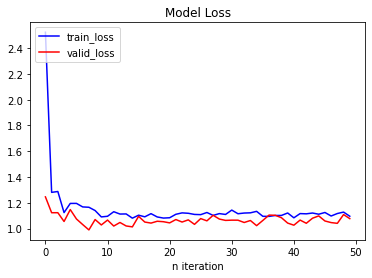

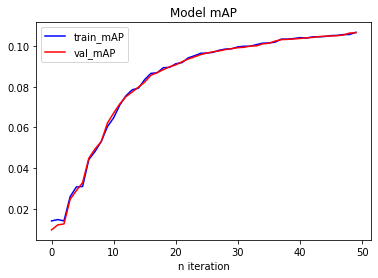

In [ ]:
plt.plot(range(num_epochs), train_loss_values, '-b', label='train_loss')
plt.plot(range(num_epochs), valid_loss_values, '-r', label='valid_loss')

plt.xlabel("n iteration")
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.show()

plt.plot(range(num_epochs), train_mAPs, '-b', label='train_mAP')
plt.plot(range(num_epochs), val_mAPs, '-r', label='val_mAP')
plt.xlabel("n iteration")

plt.legend(loc='upper left')
plt.title('Model mAP')
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model/model.pt'))

<All keys matched successfully>

In [ ]:
def evaluate(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images , targets in test_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            out = model(images)
            scores = out[0]['scores'].cpu().numpy()
            inds = scores > 0.7
            bxs = out[0]['boxes'].cpu().numpy()
            bxs = bxs[inds]
            gt = targets[0]['boxes'].cpu().numpy()
            # gt = gt[0]
            img = images[0].permute(1, 2, 0).cpu().numpy()
            #----------------------------------------------------------
            fig, ax = plt.subplots(figsize=(20, 20))
            ax.imshow(img)
            for j in range(len(gt)):
                rect1 = patches.Rectangle((int(gt[j][0]),int(gt[j][1])),abs(gt[j][0]-gt[j][2]),
                                abs(gt[j][1]-gt[j][3]),linewidth=2,edgecolor='g',facecolor='none')
                ax.add_patch(rect1)
            for i in range(len(bxs)):
                rect = patches.Rectangle((int(bxs[i][0]),int(bxs[i][1])),abs(bxs[i][0]-bxs[i][2]),
                                         abs(bxs[i][1]-bxs[i][3]),linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            fig.savefig("/content/drive/MyDrive/birds/output_images/{}.png".format(cnt), dpi=90, bbox_inches='tight')
            plt.clf()
            cnt = cnt + 1
            
            metric.update(out, targets)
            print("mAP : ",metric.compute()['map'].item())

In [ ]:
!rm /content/drive/MyDrive/birds/output_images/*.*
evaluate(model, valid_loader)

(2160, 3840, 3)


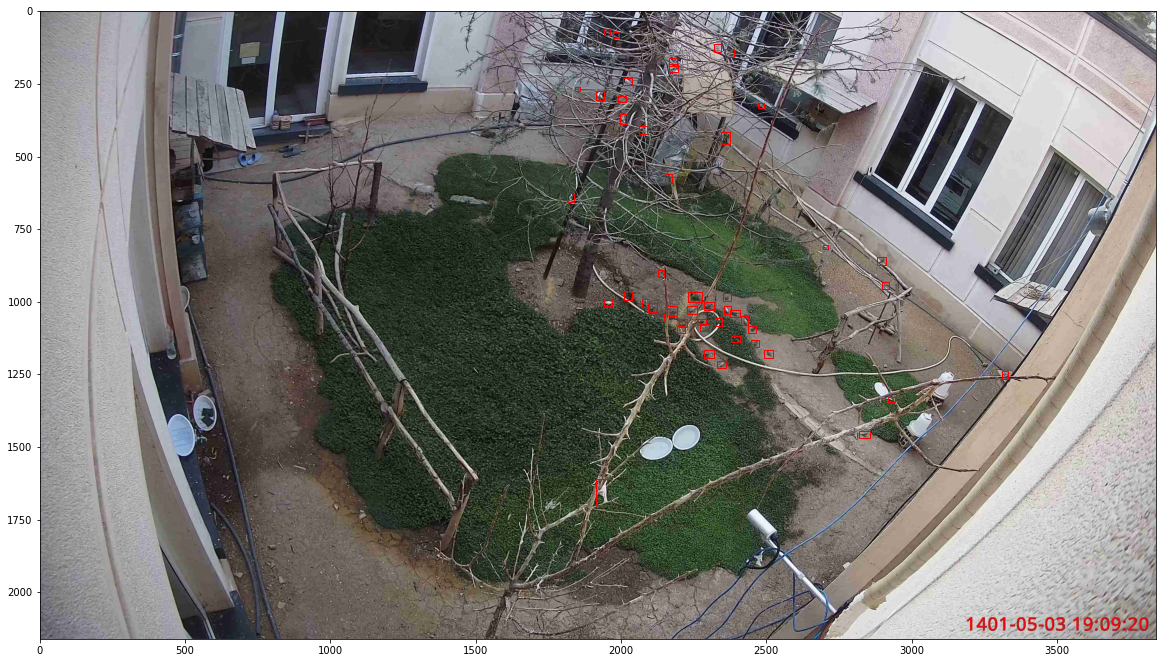

In [ ]:
img,gt=valid_dataset.__getitem__(1)
fig, ax = plt.subplots(figsize=(20, 20))

img=img.permute(1, 2, 0).cpu().numpy()
print(img.shape)
gt=gt['boxes'].cpu().numpy()
w_img,h_img=img.shape[0],img.shape[1]
ax.imshow(img)
window_name = 'Image'
for j in range(len(gt)):
    yolo_bbox1 = (gt[j][0], gt[j][1], gt[j][2], gt[j][3])
    x1, y1, x2, y2=(gt[j][0], gt[j][1], gt[j][2], gt[j][3])
    rect1 = patches.Rectangle((x1,y1),abs(x1-x2),
                               abs(y1-y2),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)